In [298]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import  matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
text_width = 7.16
column_width = 3.15

font = {'family' : 'Times New Roman',
        'size'   : 9}
params = {'text.usetex': False, 'mathtext.fontset': 'cm'}
plt.rcParams.update(params)
mpl.rc('font', **font)
plt.rcParams['text.latex.preamble'] = r"\usepackage{siunitx} \sisetup{detect-all} \usepackage{helvet} \usepackage{sansmath} \sansmath"   

# Load data

In [3]:
df = pd.read_csv("aggregated_listening_test_data.csv")  

print (df.columns)

Index(['Unnamed: 0', 'session_test_id', 'participantId', 'age', 'experience',
       'trial_id', 'choice_answer', 'choice_time', 'choice_comment', 'model',
       'sameSpeaker', 'room'],
      dtype='object')


In [4]:
# Extract necessary columns
subject_column = "participantId"   
model_column = "model"       
response_column = "choice_answer"    
setting_column = "sameSpeaker" 
room_column = "room"


# Ensure categorical indexing (convert subject & model IDs into numerical indices)
df["subject_idx"] = df[subject_column].astype("category").cat.codes
df["model_idx"] = df[model_column].astype("category").cat.codes
df["setting_idx"] = df[setting_column].astype("category").cat.codes
df["room_idx"] = df[room_column].astype("category").cat.codes


# Extract the numerical arrays for modeling
subject_ids = df["subject_idx"].values  # Subjects as categorical indices
model_ids = df["model_idx"].values      # Models as categorical indices
setting_ids = df["setting_idx"].values 
room_ids = df["room_idx"].values 


responses_ = df[response_column].values  # Binary correctness responses
responses = responses_.copy()
responses[responses == "correct"] =  1.0
responses[responses == "incorrect"] = 0.0
responses = np.int64(responses)
df["response"] = responses



# Get the number of unique subjects and models
n_subjects = df["subject_idx"].nunique()
n_models = df["model_idx"].nunique()
n_settings = df["setting_idx"].nunique()
n_rooms = df["room_idx"].nunique()

# Define coordinate system
coords = {
    "subjects": np.arange(n_subjects),
    "models": np.arange(n_models),
    "settings" : np.arange(n_settings),
    "rooms" : np.arange(n_rooms),
}

# EDA : Plot the correct/incorrect distribution for each of the test setting

In [5]:
df

,Unnamed: 0,session_test_id,participantId,age,experience,trial_id,choice_answer,choice_time,choice_comment,model,sameSpeaker,room,subject_idx,model_idx,setting_idx,room_idx,response
0,0,tp_eval_pid10,10,31,4,Q58__MIT_IR_Survey__h110_Office_MeetingRoom_1t...,incorrect,2136235,NaN,echo_density,0.0,OfficeMeetingRoom,0,1,0,6,0
1,1,tp_eval_pid10,10,31,4,Q69__MIT_IR_Survey__h042_Hallway_ElementarySch...,correct,16968,NaN,echo_density,1.0,HallwayElementarySchool,0,1,1,4,1
2,2,tp_eval_pid10,10,31,4,Q80__MIT_IR_Survey__h229_Office_Lobby_1txts__d...,incorrect,32857,NaN,fdn,0.0,OfficeLobby,0,2,0,5,0
3,3,tp_eval_pid10,10,31,4,Q15__MIT_IR_Survey__h110_Office_MeetingRoom_1t...,correct,8875,NaN,rt2rir_direct_only,1.0,OfficeMeetingRoom,0,5,1,6,1
4,4,tp_eval_pid10,10,31,4,Q62__MIT_IR_Survey__h027_Classroom_8txts__diff...,correct,13095,NaN,echo_density,0.0,Classroom,0,1,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,1675,tp_eval_pid29,29,37,5,Q10__MIT_IR_Survey__h229_Office_Lobby_1txts__d...,incorrect,31384,NaN,rt2rir,0.0,OfficeLobby,18,4,0,5,0
1676,1676,tp_eval_pid29,29,37,5,Q50__MIT_IR_Survey__h163_Bathroom_1txts__diffS...,correct,16774,NaN,fins,0.0,Bathroom,18,3,0,0,1
1677,1677,tp_eval_pid29,29,37,5,Q80__MIT_IR_Survey__h229_Office_Lobby_1txts__d...,correct,15222,NaN,fdn,0.0,OfficeLobby,18,2,0,5,1
1678,1678,tp_eval_pid29,29,37,5,Q67__MIT_IR_Survey__h025_Diningroom_8txts__sam...,correct,6586,NaN,echo_density,1.0,Diningroom,18,1,1,3,1


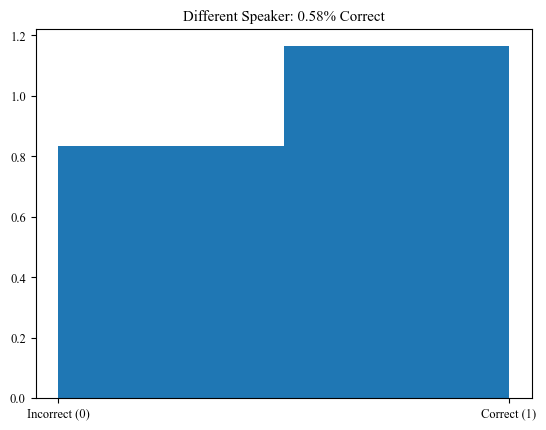

Text(0.5, 1.0, 'Same Speaker: 0.85% Correct')

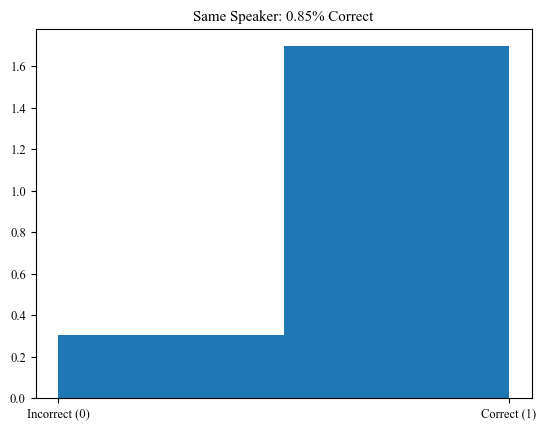

In [10]:
diff_df = df[df["setting_idx"] == 0]
same_df = df[df["setting_idx"] == 1]

diff_speaker_detection_rate = diff_df["response"].sum() / len(diff_df)
same_speaker_detection_rate = same_df["response"].sum() / len(same_df)

plt.hist(diff_df["response"], bins=2, density=True)
plt.xticks([0, 1], ["Incorrect (0)", "Correct (1)"])
plt.title(f"Different Speaker: {diff_speaker_detection_rate:.2f}% Correct")
plt.show()


plt.hist(same_df["response"], bins=2, density=True)
plt.xticks([0, 1], ["Incorrect (0)", "Correct (1)"])
plt.title(f"Same Speaker: {same_speaker_detection_rate:.2f}% Correct")


In [11]:
# Map index to name 


model_idx_to_name = dict(zip(df["model_idx"], df[model_column]))

# Display the dictionary
print(model_idx_to_name)

model_idx_to_name[5] = "RT2RIR"
model_idx_to_name[4] = "RT2RIR-LateOnly"
model_idx_to_name[0] = "DarkVelvetNoise"
model_idx_to_name[1] = "EchoDensity"
model_idx_to_name[2] = "FDN"
model_idx_to_name[3] = "FiNS"

print(model_idx_to_name)

model_labels = [model_idx_to_name[i] for i in sorted(model_idx_to_name.keys())]
print (model_labels)

{1: 'echo_density', 2: 'fdn', 5: 'rt2rir_direct_only', 4: 'rt2rir', 0: 'dark_velvet_noise', 3: 'fins'}
{1: 'EchoDensity', 2: 'FDN', 5: 'RT2RIR', 4: 'RT2RIR-LateOnly', 0: 'DarkVelvetNoise', 3: 'FiNS'}
['DarkVelvetNoise', 'EchoDensity', 'FDN', 'FiNS', 'RT2RIR-LateOnly', 'RT2RIR']


In [12]:
room_idx_to_name = dict(zip(df["room_idx"], df[room_column]))
print (room_idx_to_name)

room_labels = [room_idx_to_name[i] for i in sorted(room_idx_to_name.keys())]
print (room_labels)

{6: 'OfficeMeetingRoom', 4: 'HallwayElementarySchool', 5: 'OfficeLobby', 2: 'Classroom', 0: 'Bathroom', 1: 'Bedroom', 3: 'Diningroom'}
['Bathroom', 'Bedroom', 'Classroom', 'Diningroom', 'HallwayElementarySchool', 'OfficeLobby', 'OfficeMeetingRoom']


In [13]:
# Define a modified sigmoid function for 3AFC task

# A pymc version 
def shifted_sigmoid_tensor(logits, min_prob=0.333):
    # Ensure probability is between [0.333, 1]
    return min_prob + (1 - min_prob) * pm.math.invlogit(logits)

# Numpy version
def shifted_sigmoid(logits, min_prob=0.333):
    # Ensure probability is between [0.333, 1]
    return min_prob + (1 - min_prob) * (1 / (1 + np.exp(-logits)))


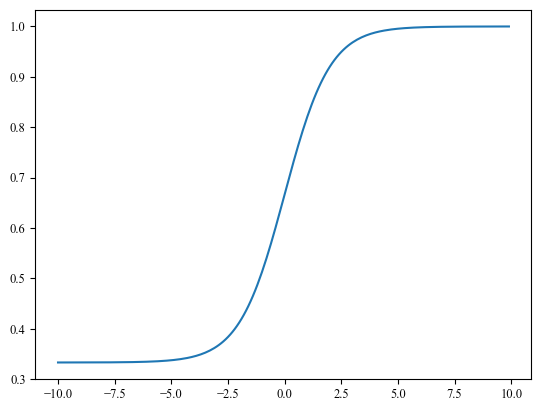

In [14]:
x = np.arange(-10,10, 0.1)

y = shifted_sigmoid(x)

plt.plot(x,y)

# Define pymc model and sample

In [156]:

with pm.Model(coords=coords) as model:
    # Subject-specific acuity (latent variable)
    beta = pm.Normal("subject_acuity", mu=0, sigma=0.2, dims="subjects")
    
    # Model-specific competency
    gamma = pm.Normal("model_competency", mu=0, sigma=0.5, dims="models")
    
    # Effect of test setting (same vs diff speaker)
    delta_means = np.array([-0.5, 0.5])  # Mean for [diff-speaker, same-speaker]
    delta = pm.Normal("test_setting", mu=delta_means, sigma=0.5, dims="settings")
    
    # Room 
    theta = pm.Normal("room_effect", mu=0, sigma=0.2, dims="rooms")

    # Compute logit
    logits = beta[subject_ids] + gamma[model_ids] + delta[setting_ids] + theta[room_ids] # + theta_rt60 * rt60_list + theta_c50 * c50_list 
    
    
    # Convert logits to probabilty : probability of observing a correct response with the logistic regression model
    # Use shifted sigmoid to ensure probabilities between [0.333, 1]
    p = pm.Deterministic("p", shifted_sigmoid_tensor(logits, min_prob=0.333))
    
    # Likelihood function (observed response)
    y = pm.Bernoulli("y", p=p, observed=responses)
    
    #sampling
    trace = pm.sample(4000, tune=800, target_accept=0.9)
    

    pm.sample_posterior_predictive(
        trace, extend_inferencedata=True
    )
    
    # Sample from the prior predictive distribution
    prior_trace = pm.sample_prior_predictive(draws=1000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [subject_acuity, model_competency, test_setting, room_effect]


Output()

Sampling 4 chains for 800 tune and 4_000 draw iterations (3_200 + 16_000 draws total) took 12 seconds.
Sampling: [y]


Output()

Sampling: [model_competency, room_effect, subject_acuity, test_setting, y]


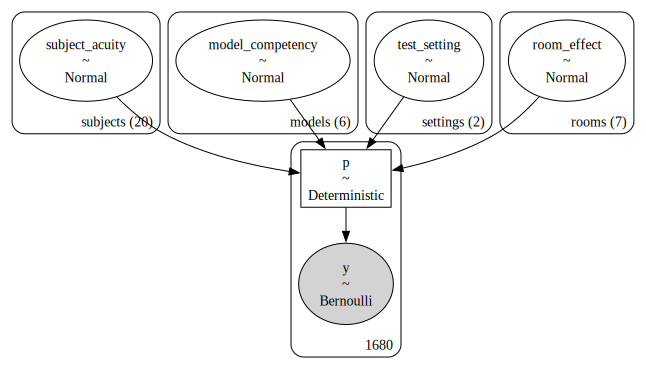

In [158]:
pm.model_to_graphviz(model)

In [159]:
gv = pm.model_to_graphviz(model)
gv.render(filename='pymc_model',format='pdf')

'pymc_model.pdf'

# Plot prior and posterior distribution

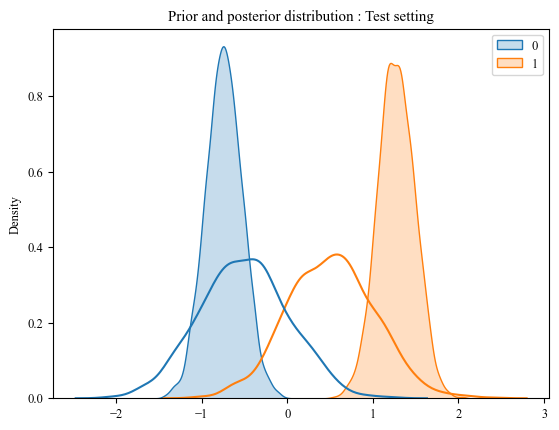

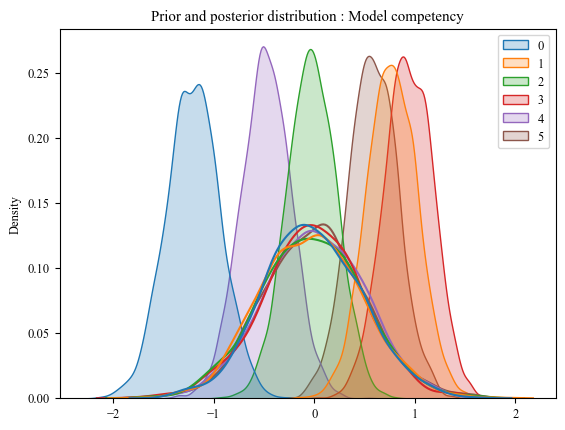

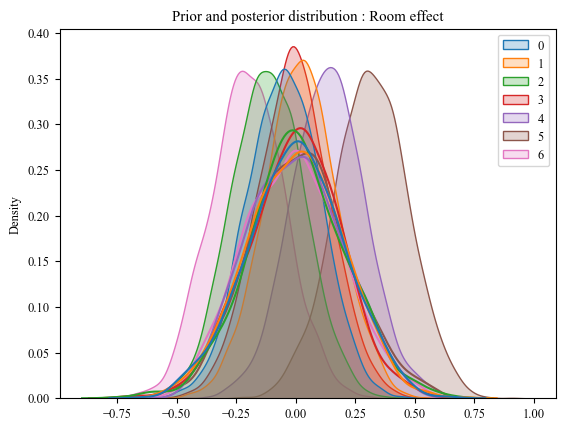

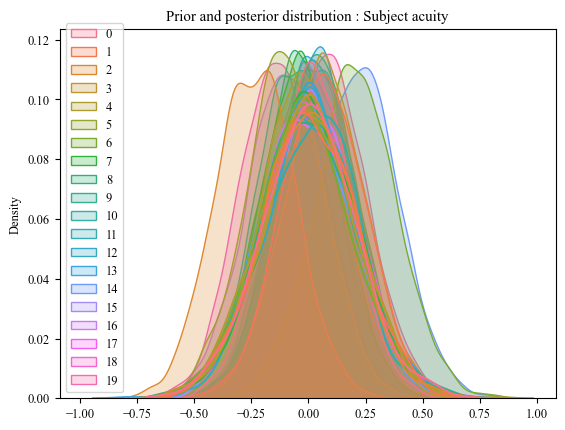

In [160]:
sns.kdeplot(prior_trace.prior["test_setting"][0], )
sns.kdeplot(trace.posterior["test_setting"][0],  fill=True)
plt.title("Prior and posterior distribution : Test setting")
# plt.legend()
plt.show()

sns.kdeplot(prior_trace.prior["model_competency"][0],)
sns.kdeplot(trace.posterior["model_competency"][0],  fill=True)
plt.title("Prior and posterior distribution : Model competency")
# plt.legend()
plt.show()

sns.kdeplot(prior_trace.prior["room_effect"][0],)
sns.kdeplot(trace.posterior["room_effect"][0],  fill=True)
plt.title("Prior and posterior distribution : Room effect")
# plt.legend()
plt.show()

sns.kdeplot(prior_trace.prior["subject_acuity"][0],)
sns.kdeplot(trace.posterior["subject_acuity"][0], fill=True)
plt.title("Prior and posterior distribution : Subject acuity")
# plt.legend()
plt.show()

# Plot prior predictive 


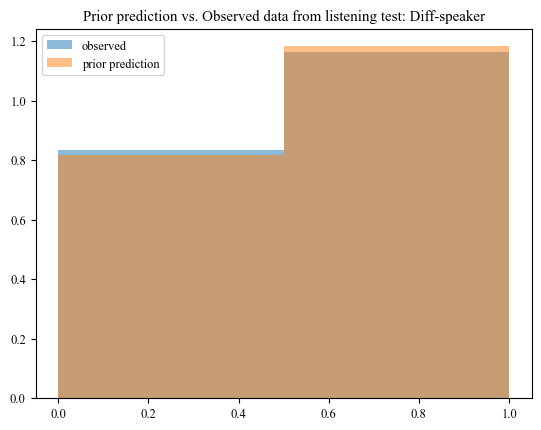

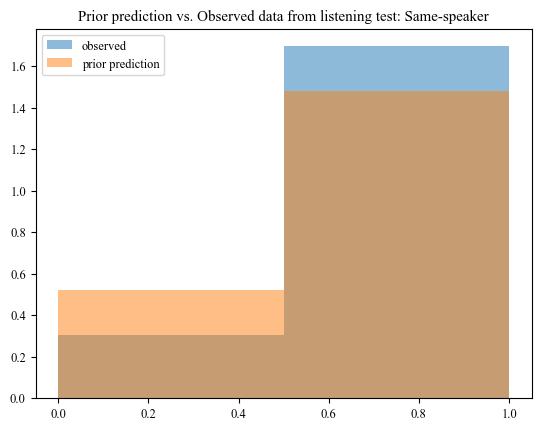

In [161]:

# Index of diff /same speaker setting 
id_same_speaker = np.where(setting_ids == 1)[0]
id_diff_speaker = np.where(setting_ids == 0)[0]

same_speaker_prior_predictive = np.array(prior_trace.prior_predictive["y"][0][:, id_same_speaker]).reshape(-1)
diff_speaker_prior_predictive = np.array(prior_trace.prior_predictive["y"][0][:, id_diff_speaker]).reshape(-1)

plt.hist(diff_df["response"], bins=2, density=True, alpha=0.5, label="observed")
plt.hist(diff_speaker_prior_predictive, bins=2, density=True, alpha=0.5, label="prior prediction")
plt.legend()
plt.title("Prior prediction vs. Observed data from listening test: Diff-speaker")
plt.show()

plt.hist(same_df["response"], bins=2, density=True, alpha=0.5, label="observed")
plt.hist(same_speaker_prior_predictive, bins=2, density=True, alpha=0.5, label="prior prediction")
plt.title("Prior prediction vs. Observed data from listening test: Same-speaker")

plt.legend()

# Plot posterior prediction

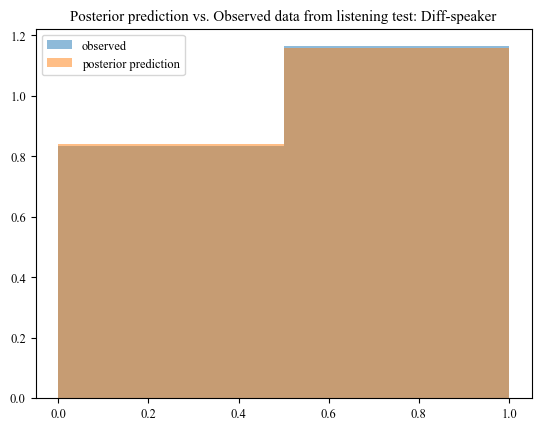

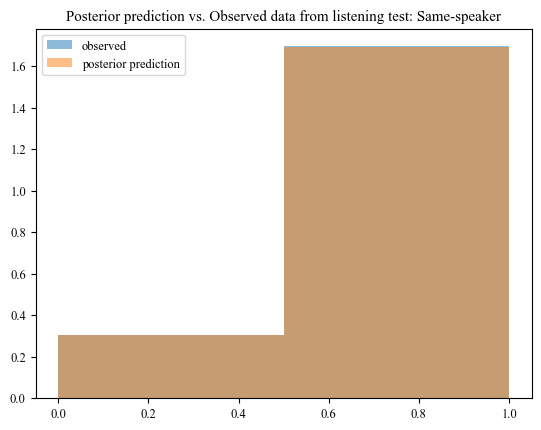

In [162]:
same_speaker_posterior_predictive = np.array(trace.posterior_predictive["y"][0][:, id_same_speaker]).reshape(-1)
diff_speaker_posterior_predictive = np.array(trace.posterior_predictive["y"][0][:, id_diff_speaker]).reshape(-1)

plt.hist(diff_df["response"], bins=2, density=True, alpha=0.5, label="observed")
plt.hist(diff_speaker_posterior_predictive, bins=2, density=True, alpha=0.5, label="posterior prediction")
plt.legend()
plt.title("Posterior prediction vs. Observed data from listening test: Diff-speaker")
plt.show()

plt.hist(same_df["response"], bins=2, density=True, alpha=0.5, label="observed")
plt.hist(same_speaker_posterior_predictive, bins=2, density=True, alpha=0.5, label="posterior prediction")
plt.title("Posterior prediction vs. Observed data from listening test: Same-speaker")
plt.legend()

In [163]:
# Reassign coordinate labels for settings in the trace
trace = trace.assign_coords(settings=["diff-speaker", "same-speaker"])
trace = trace.assign_coords(models=model_labels)
trace = trace.assign_coords(rooms=room_labels)

# Define the label mapping for ArviZ
labeller = az.labels.MapLabeller(var_name_map={"subject_acuity": r"$\beta$","model_competency": r"$\gamma$", "test_setting": r"$\delta$","room_effect": r"$\theta$",})


array([[<Axes: title={'center': 'test_setting'}>,
        <Axes: title={'center': 'test_setting'}>]], dtype=object)

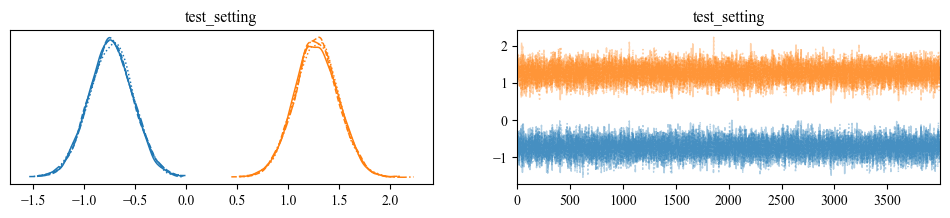

In [164]:
az.plot_trace(trace, var_names=["test_setting"])#, "room_effect", "subject_acuity", "model_detectability"])

array([[<Axes: title={'center': 'test_setting'}>,
        <Axes: title={'center': 'test_setting'}>],
       [<Axes: title={'center': 'room_effect'}>,
        <Axes: title={'center': 'room_effect'}>],
       [<Axes: title={'center': 'subject_acuity'}>,
        <Axes: title={'center': 'subject_acuity'}>],
       [<Axes: title={'center': 'model_competency'}>,
        <Axes: title={'center': 'model_competency'}>]], dtype=object)

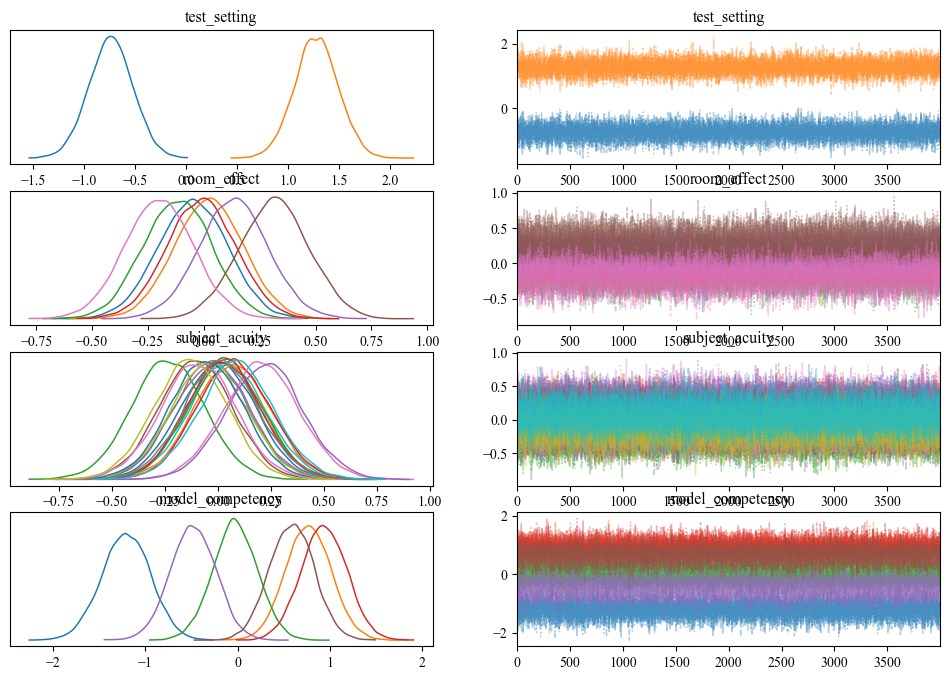

In [165]:
az.plot_trace(trace, var_names=["test_setting", "room_effect", "subject_acuity", "model_competency"], combined=True)

In [166]:
stat_df = az.summary(trace, var_names=[ "test_setting", "model_competency", "room_effect", "subject_acuity"])
stat_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
test_setting[diff-speaker],-0.739,0.216,-1.156,-0.344,0.002,0.001,10443.0,11601.0,1.0
test_setting[same-speaker],1.273,0.214,0.883,1.689,0.002,0.001,10676.0,11886.0,1.0
model_competency[DarkVelvetNoise],-1.211,0.266,-1.720,-0.723,0.002,0.002,13772.0,13249.0,1.0
model_competency[EchoDensity],0.764,0.248,0.311,1.238,0.002,0.002,12918.0,12492.0,1.0
model_competency[FDN],-0.030,0.243,-0.510,0.411,0.002,0.002,12249.0,13084.0,1.0
model_competency[FiNS],0.934,0.248,0.462,1.392,0.002,0.002,12723.0,12845.0,1.0
model_competency[RT2RIR-LateOnly],-0.483,0.249,-0.949,-0.017,0.002,0.002,12949.0,13108.0,1.0
model_competency[RT2RIR],0.584,0.242,0.134,1.038,0.002,0.002,12151.0,12389.0,1.0
room_effect[Bathroom],-0.050,0.156,-0.336,0.247,0.001,0.001,26145.0,11627.0,1.0
room_effect[Bedroom],0.022,0.154,-0.262,0.319,0.001,0.001,27617.0,11593.0,1.0


In [302]:
np.exp(0)

1.0

In [167]:
# Convert coefficients to effect on odds
stat_df = az.summary(trace, var_names=[ "test_setting", "model_competency", "room_effect", "subject_acuity"],kind="stats")
stat_df['odds_ratio'] = np.exp(stat_df['mean'])
stat_df['percentage_effect'] = 100 * (stat_df['odds_ratio'] - 1)
stat_df

,mean,sd,hdi_3%,hdi_97%,odds_ratio,percentage_effect
test_setting[diff-speaker],-0.739,0.216,-1.156,-0.344,0.477591,-52.240873
test_setting[same-speaker],1.273,0.214,0.883,1.689,3.571551,257.155116
model_competency[DarkVelvetNoise],-1.211,0.266,-1.720,-0.723,0.297899,-70.210077
model_competency[EchoDensity],0.764,0.248,0.311,1.238,2.146846,114.684645
model_competency[FDN],-0.030,0.243,-0.510,0.411,0.970446,-2.955447
model_competency[FiNS],0.934,0.248,0.462,1.392,2.544668,154.466752
model_competency[RT2RIR-LateOnly],-0.483,0.249,-0.949,-0.017,0.616930,-38.307018
model_competency[RT2RIR],0.584,0.242,0.134,1.038,1.793197,79.319689
room_effect[Bathroom],-0.050,0.156,-0.336,0.247,0.951229,-4.877058
room_effect[Bedroom],0.022,0.154,-0.262,0.319,1.022244,2.224378


In [168]:
print(stat_df.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
))  

\begin{tabular}{lrrrrrr}
\toprule
 & mean & sd & hdi_3% & hdi_97% & odds_ratio & percentage_effect \\
\midrule
test_setting[diff-speaker] & -0.74 & 0.22 & -1.16 & -0.34 & 0.48 & -52.24 \\
test_setting[same-speaker] & 1.27 & 0.21 & 0.88 & 1.69 & 3.57 & 257.16 \\
model_competency[DarkVelvetNoise] & -1.21 & 0.27 & -1.72 & -0.72 & 0.30 & -70.21 \\
model_competency[EchoDensity] & 0.76 & 0.25 & 0.31 & 1.24 & 2.15 & 114.68 \\
model_competency[FDN] & -0.03 & 0.24 & -0.51 & 0.41 & 0.97 & -2.96 \\
model_competency[FiNS] & 0.93 & 0.25 & 0.46 & 1.39 & 2.54 & 154.47 \\
model_competency[RT2RIR-LateOnly] & -0.48 & 0.25 & -0.95 & -0.02 & 0.62 & -38.31 \\
model_competency[RT2RIR] & 0.58 & 0.24 & 0.13 & 1.04 & 1.79 & 79.32 \\
room_effect[Bathroom] & -0.05 & 0.16 & -0.34 & 0.25 & 0.95 & -4.88 \\
room_effect[Bedroom] & 0.02 & 0.15 & -0.26 & 0.32 & 1.02 & 2.22 \\
room_effect[Classroom] & -0.12 & 0.15 & -0.40 & 0.17 & 0.89 & -11.22 \\
room_effect[Diningroom] & -0.01 & 0.15 & -0.31 & 0.27 & 0.99 & -1.19 \\
r

# Sensitivity analysis

In [108]:
import pymc as pm
import arviz as az

# Define a function to run the model with different priors
def run_model(sd):
    with pm.Model(coords=coords) as model:
        # Priors with different standard deviations
        beta = pm.Normal("subject_acuity", mu=0, sigma=sd, dims="subjects")
        gamma = pm.Normal("model_detectability", mu=0, sigma=sd, dims="models")
        delta = pm.Normal("test_setting", mu=[-0.5, 0.5], sigma=sd, dims="settings")
        theta = pm.Normal("room_effect", mu=0, sigma=sd, dims="rooms")

        # Compute logits
        logits = beta[subject_ids] + gamma[model_ids] + delta[setting_ids] + theta[room_ids]
      
        # Convert logits to probability
        # p = pm.math.invlogit(logits)
        p = shifted_sigmoid_tensor(logits)

        # Likelihood
        y_obs = pm.Bernoulli("y_obs", p=p, observed=responses)

        # Sample from the posterior
        trace_test = pm.sample(2000, tune=500, target_accept=0.9)
    
    return trace_test

# Run models with different prior strengths
trace_weak = run_model(sd=1.0)  # Weak Prior
trace_moderate = run_model(sd=0.5)  # Moderate Prior
trace_strong = run_model(sd=0.5)  # Strong Prior

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [subject_acuity, model_detectability, test_setting, room_effect]


Output()

Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 8 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [subject_acuity, model_detectability, test_setting, room_effect]


Output()

Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 6 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [subject_acuity, model_detectability, test_setting, room_effect]


Output()

Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 6 seconds.


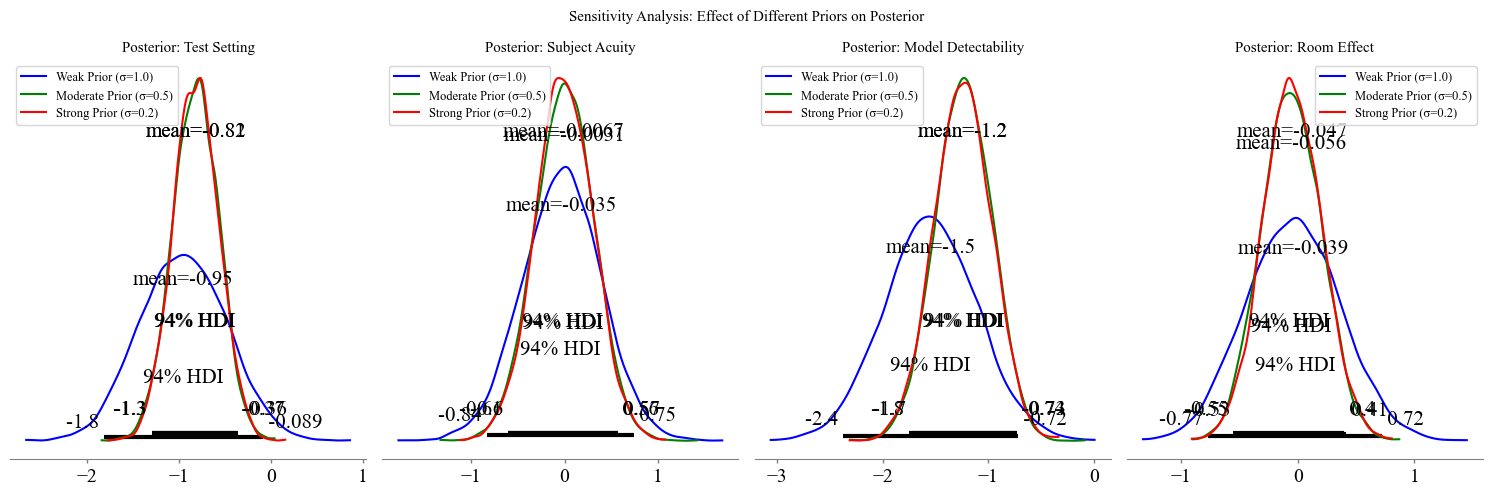

In [110]:
# Compare posterior distributions
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i, (trace, label, color) in enumerate(zip(
    [trace_weak, trace_moderate, trace_strong], 
    ["Weak Prior (σ=1.0)", "Moderate Prior (σ=0.5)", "Strong Prior (σ=0.2)"],
    ["blue", "green", "red"]
)):
    az.plot_posterior(trace, var_names=["test_setting"], ax=axes[0], color=color, label=label)
    az.plot_posterior(trace, var_names=["subject_acuity"], ax=axes[1], color=color, label=label)
    az.plot_posterior(trace, var_names=["model_detectability"], ax=axes[2], color=color, label=label)
    az.plot_posterior(trace, var_names=["room_effect"], ax=axes[3], color=color, label=label)

axes[0].set_title("Posterior: Test Setting")
axes[1].set_title("Posterior: Subject Acuity")
axes[2].set_title("Posterior: Model Detectability")
axes[3].set_title("Posterior: Room Effect")

plt.suptitle("Sensitivity Analysis: Effect of Different Priors on Posterior")
plt.legend()
plt.tight_layout()
plt.show()

# Posterior Contrast: Test Setting Effect on Detection Rate

🔹 If delta > 0, detection is higher in the same-speaker condition.

🔹 If delta < 0, detection is higher in the diff-speaker condition.

array([<Axes: title={'center': 'test_setting\ndiff-speaker'}>,
       <Axes: title={'center': 'test_setting\nsame-speaker'}>],
      dtype=object)

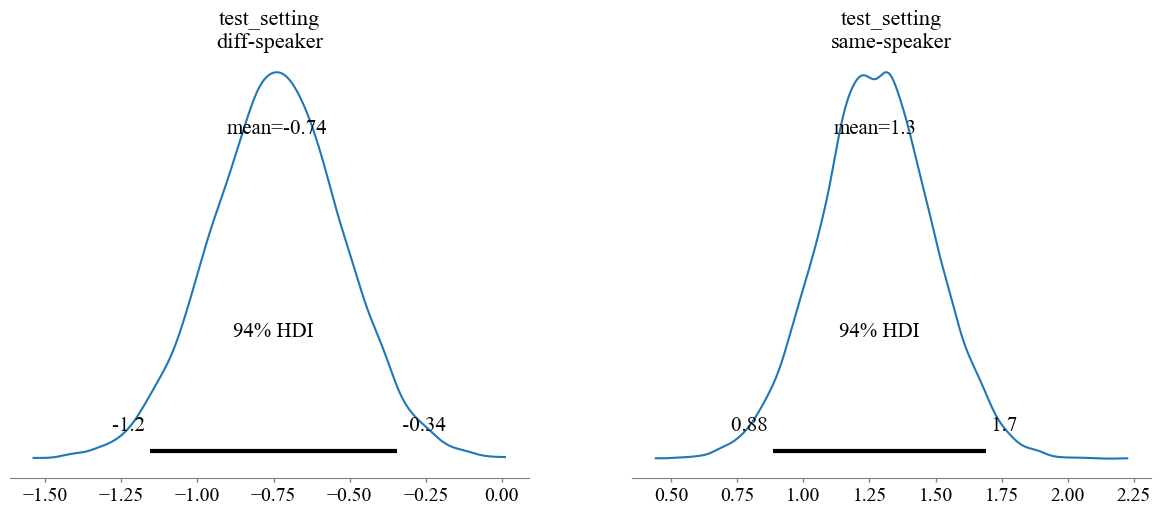

In [169]:
# labeller = az.labels.MapLabeller(var_name_map={"test_setting": r"$\delta$"})
# coords = {"settings": ["diff","same"]}

az.plot_posterior(trace, var_names=["test_setting"])#, coords=coords, labeller=labeller)

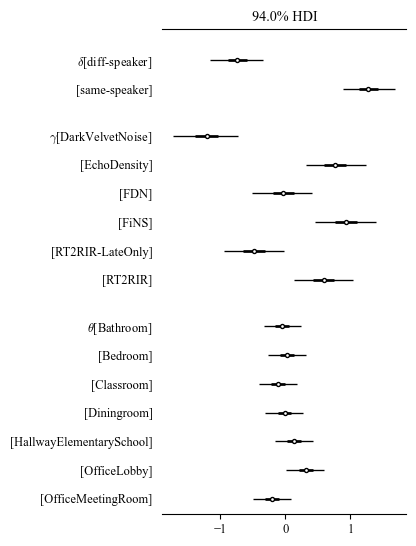

In [293]:
az.plot_forest(trace,var_names=["test_setting", "model_competency", "room_effect"], combined=True,
        figsize=(column_width, column_width*2),
                 textsize=9,
              labeller=labeller, 
               colors="black"
#                kind="ridgeplot",
#                colors='white',
#                ridgeplot_overlap=0.8,
#                linewidth=3,
#                ridgeplot_quantiles=[0.5],
              
              )

plt.savefig("forsest_plot_posterior.pdf", bbox_inches='tight')
plt.show()

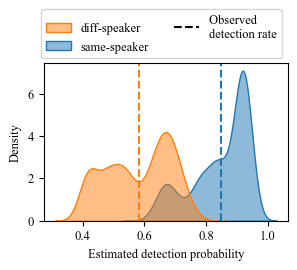

In [299]:
plt.figure(figsize=(column_width, column_width * 0.65))

same_speaker_p = trace.posterior["p"][:, :, id_same_speaker]
diff_speaker_p = trace.posterior["p"][:, :, id_diff_speaker]

same_speaker_p_mean = same_speaker_p.mean(dim=["chain", "draw"])
diff_speaker_p_mean = diff_speaker_p.mean(dim=["chain", "draw"])


plt.plot([], [], '--', color="black", label="Observed \ndetection rate")
sns.kdeplot(same_speaker_p_mean, label="same-speaker", linewidth=1, fill=True, color="C0" , alpha=0.5)
sns.kdeplot(diff_speaker_p_mean, label="diff-speaker", linewidth=1, fill=True, color="C1" , alpha=0.5)

plt.axvline(same_speaker_detection_rate, color="C0", linestyle='--',)
plt.axvline(diff_speaker_detection_rate, color="C1", linestyle='--',)


# Add labels and title
plt.xlabel("Estimated detection probability")
plt.ylabel("Density")


# plt.title("Posterior Distributions of Detection Rate for Each Test Setting", y=1.2)
plt.legend(ncols=2, bbox_to_anchor=(1.0, 1.38), reverse=True)



plt.savefig("posterior_dist_detection_rate.pdf", bbox_inches='tight')

# plt.tight_layout()
plt.show()

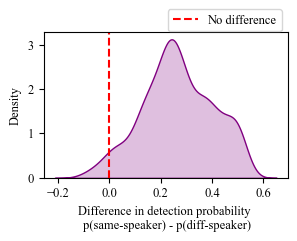

Probability that detection rate is higher in Same-Speaker setting: 0.971


In [300]:
plt.figure(figsize=(column_width, column_width * 0.6))


# Compute posterior contrast (difference in detection probability)
delta_diff = same_speaker_p_mean.values - diff_speaker_p_mean.values

# Plot posterior distribution of the difference
sns.kdeplot(delta_diff, fill=True, color="purple")
plt.axvline(0, color='red', linestyle='--', label="No difference")  # Reference line at 0

# Add labels and title
plt.xlabel("Difference in detection probability \n p(same-speaker) - p(diff-speaker)")
plt.ylabel("Density")
# plt.title("P"osterior Contrast: Effect of Test Setting on Detection Probability")
plt.legend(bbox_to_anchor=(1.0, 1.2))
plt.savefig("posterior_contrast.pdf", bbox_inches='tight')

# plt.subplots_adjust( hspace=0.6)

plt.show()

# Compute probability that same-speaker has higher detection rate
prob_higher_detection = (delta_diff > 0).mean()
print(f"Probability that detection rate is higher in Same-Speaker setting: {prob_higher_detection:.3f}")



# For each model 

In [204]:
model_order = ["RT2RIR-LateOnly", "RT2RIR", "EchoDensity", "FDN", "DarkVelvetNoise", "FiNS"]

{1: 'EchoDensity', 2: 'FDN', 5: 'RT2RIR', 4: 'RT2RIR-LateOnly', 0: 'DarkVelvetNoise', 3: 'FiNS'}
Curr model EchoDensity
Curr model FDN
Curr model RT2RIR
Curr model RT2RIR-LateOnly
Curr model DarkVelvetNoise
Curr model FiNS


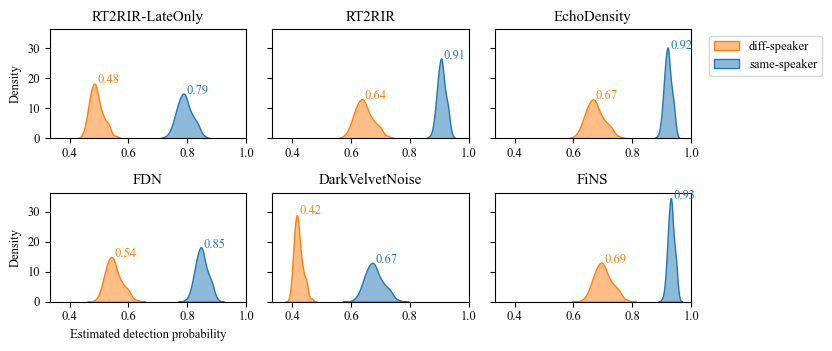

In [332]:
print(model_idx_to_name)

fig, axes = plt.subplots(2,3, figsize=(text_width, text_width * 0.5), sharex=False, sharey=True)

for k, v in model_idx_to_name.items() : 
    print ("Curr model", v)
    model_idx_new = model_order.index(v)
    row = model_idx_new //3
    col = model_idx_new %3
    
    # Index of each model
    id_curr_model = np.where(model_ids == k)[0]
    
    id_curr_model_same_speaker = np.intersect1d(id_curr_model, id_same_speaker)
    id_curr_model_diff_speaker = np.intersect1d(id_curr_model, id_diff_speaker)
    
    p_curr_model_same_speaker = trace.posterior["p"][:, :, id_curr_model_same_speaker]
    p_curr_model_diff_speaker = trace.posterior["p"][:, :, id_curr_model_diff_speaker]

    p_mean_same_speaker =  p_curr_model_same_speaker.mean(dim=["chain", "draw"])
    p_mean_diff_speaker =  p_curr_model_diff_speaker.mean(dim=["chain", "draw"])
    
    # Compute the density estimate
    same_grid, same_kde = az.kde(p_mean_same_speaker.values)
    diff_grid, diff_kde = az.kde(p_mean_diff_speaker.values)
    
    # Find the mode (MAP) as the peak of the KDE estimate
    map_same = same_grid[np.argmax(same_kde)]
    map_diff = diff_grid[np.argmax(diff_kde)]
    
    density_same = np.max(same_kde)
    density_diff = np.max(diff_kde)
    
    sns.kdeplot(p_mean_same_speaker.values, fill=True, color="C0", ax=axes[row][col], alpha=0.5, label="same-speaker")
    sns.kdeplot(p_mean_diff_speaker.values, fill=True, color="C1", ax=axes[row][col], alpha=0.5, label="diff-speaker")
#     axes[row][col].axvline(map_same, color="C0", linewidth=0.5)
#     axes[row][col].axvline(map_diff, color="C1", linewidth=0.5)
    axes[row][col].text(map_same + 0.01, density_same, f"{map_same:.2f}",color="C0", rotation=0)
    axes[row][col].text(map_diff + 0.01, density_diff, f"{map_diff:.2f}",color="C1", rotation=0)
    axes[row][col].set_title(v)

    axes[row][col].set_xlim([0.333, 1])
    
    
    # Labels and title
    axes[row][col].set_ylabel("Density")
    

axes[1][0].set_xlabel("Estimated detection probability")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.7,2.5),reverse=True)

# fig.suptitle("Posterior Distributions of Detection Rate for Each Model and Test Setting")
plt.savefig("posterior_each_model.pdf", bbox_inches='tight')
plt.show()
plt.show()

# Effect of room

{6: 'OfficeMeetingRoom', 4: 'HallwayElementarySchool', 5: 'OfficeLobby', 2: 'Classroom', 0: 'Bathroom', 1: 'Bedroom', 3: 'Diningroom'}
Curr room OfficeMeetingRoom
Curr room HallwayElementarySchool
Curr room OfficeLobby
Curr room Classroom
Curr room Bathroom
Curr room Bedroom
Curr room Diningroom


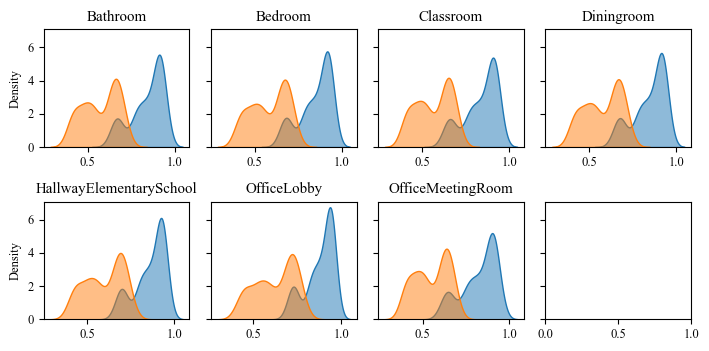

In [223]:
print(room_idx_to_name)


fig, axes = plt.subplots(2,4, figsize=(text_width, text_width * 0.5), sharex=False, sharey=True)

for k, v in room_idx_to_name.items() : 
    print ("Curr room", v)
    
    row = k //4
    col = k %4
    
    # Index of each model
    id_curr_room = np.where(room_ids == k)[0]
    
    id_curr_room_same_speaker = np.intersect1d(id_curr_room, id_same_speaker)
    id_curr_room_diff_speaker = np.intersect1d(id_curr_room, id_diff_speaker)
    
    p_curr_room_same_speaker = trace.posterior["p"][:, :, id_curr_room_same_speaker]
    p_curr_room_diff_speaker = trace.posterior["p"][:, :, id_curr_room_diff_speaker]

    p_mean_same_speaker =  p_curr_room_same_speaker.mean(dim=["chain", "draw"])
    p_mean_diff_speaker =  p_curr_room_diff_speaker.mean(dim=["chain", "draw"])


    sns.kdeplot(p_mean_same_speaker.values, fill=True, ax=axes[row][col],color="C0", alpha=0.5, label="same-speaker")
    sns.kdeplot(p_mean_diff_speaker.values, fill=True, ax=axes[row][col],color="C1",  alpha=0.5, label="diff-speaker")

    axes[row][col].set_title(v)
    
plt.tight_layout()